In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import shutil

In [2]:
#Obtenemos el nombre de las carpetas existentes en la carpeta faces
carpetas = os.listdir('faces')

In [3]:
#Creamos un array donde se guardara un 1 si la imagen tiene gafas y un 0 si no las tiene
gafas = []

In [4]:
#Creamos el directorio donde se guardaran las nuevas imagenes
os.makedirs('imagenes', exist_ok=True)

In [5]:
#Iteramos sobre las carpetas y extraemos las imagenes que no tengan gafas y las que si, ademas de guardar el valor en el array gafas
cont = 0
for i in carpetas:
  archivo_carpeta = os.listdir(f'faces/{i}')
  for archivos in archivo_carpeta:
    if not re.search(r'(2|4)\.pgm$', archivos):
      if re.search(r'sunglasses.pgm$', archivos):
        shutil.copy(f'faces/{i}/{archivos}', f'imagenes/{archivos}')
        gafas.append(1)
      elif re.search(r'\.bad$', archivos):
        continue
      else:
        shutil.copy(f'faces/{i}/{archivos}', f'imagenes/{archivos}')
        gafas.append(0)

In [6]:
#Creamos el dataframe con los datos obtenidos
df = pd.DataFrame({'Image': os.listdir('imagenes'), 'Sunglasses': gafas})

In [7]:
#Observamos las primeras entradas del dataframe
df.head()

,Image,Sunglasses
0,an2i_left_angry_open.pgm,0
1,an2i_left_angry_sunglasses.pgm,1
2,an2i_left_happy_open.pgm,0
3,an2i_left_happy_sunglasses.pgm,1
4,an2i_left_neutral_open.pgm,0


In [8]:
#Guardamos el dataframe en un csv
df.to_csv('data_imagenes.csv', index=False)

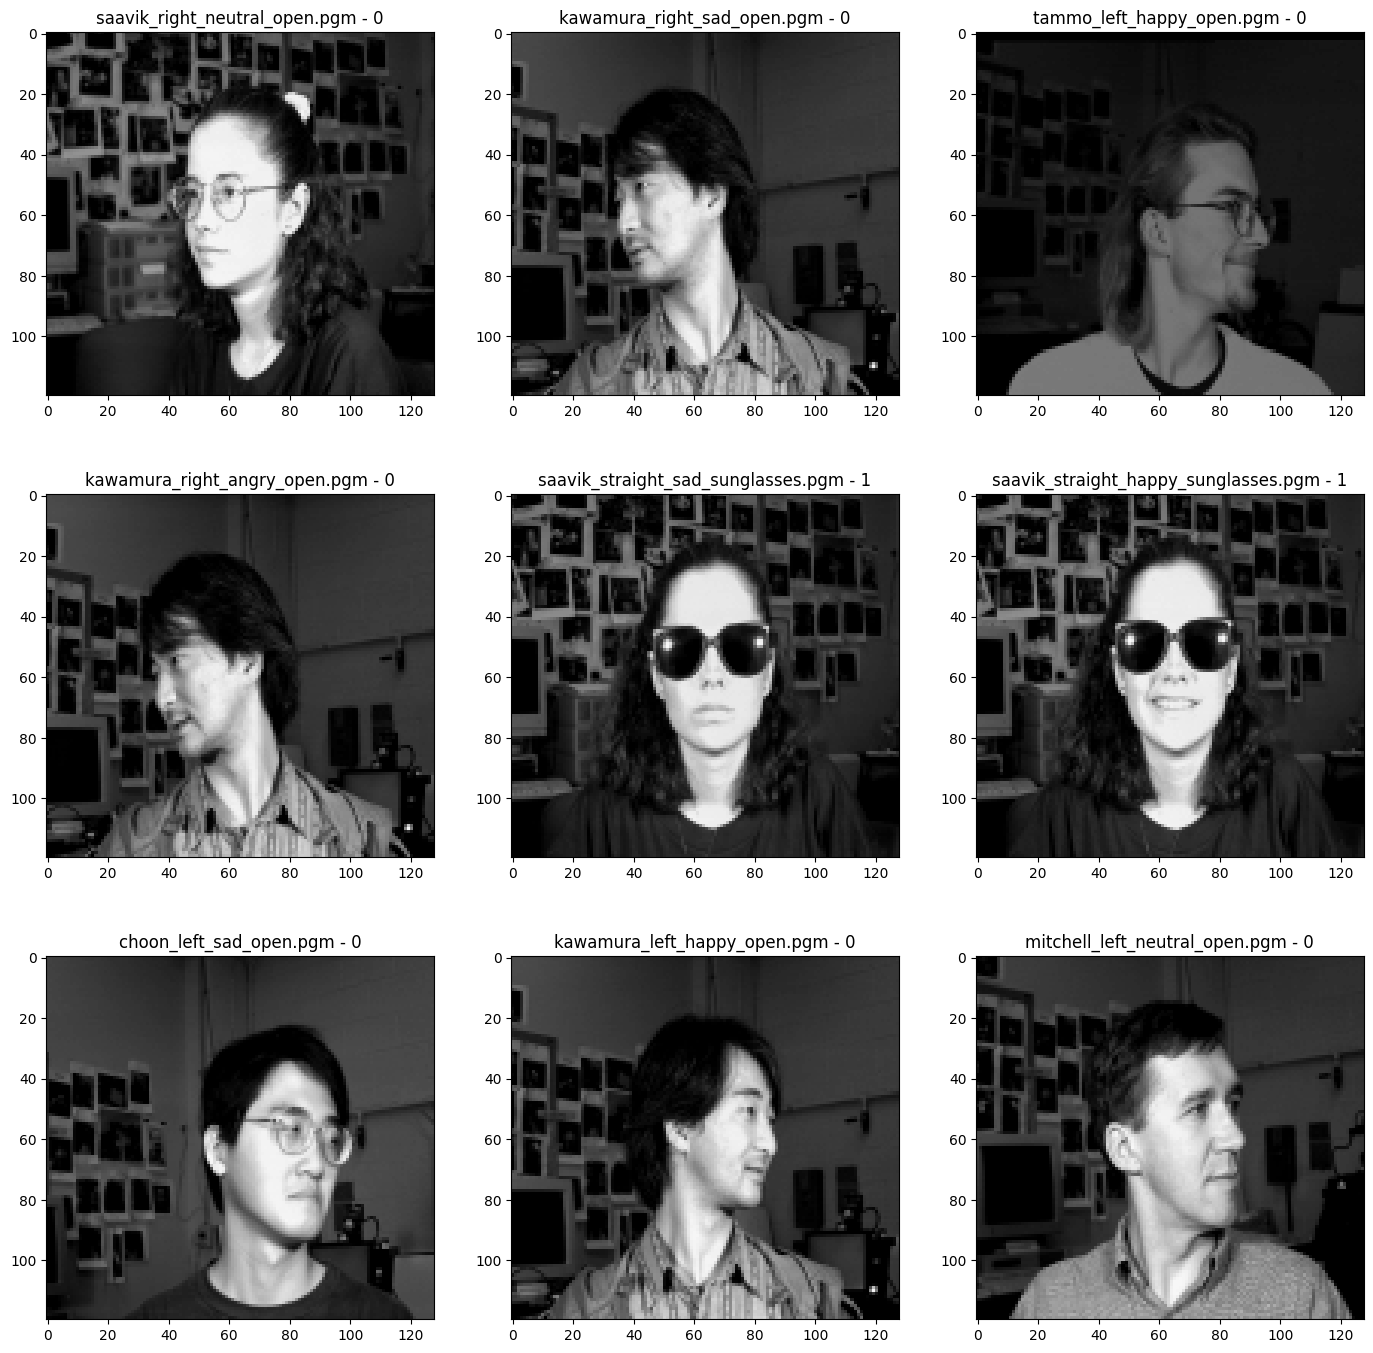

In [9]:
#Graficamos una muestra aleatoria de 9 imagenes para comprobar que se hizo el etiquetado correctamente
fig, ax = plt.subplots(3,3 ,figsize=(17,17))
for i in ax.flatten():
  nombre, etiqueta = df.sample().values[0]
  img = cv2.imread(f'imagenes/{nombre}')
  i.imshow(img)
  i.title.set_text(f'{nombre} - {etiqueta}')